## Inicializacao

In [9]:
import numpy as np
import pandas as pd
import sympy as sp
import scipy.io as sc 
from sympy import symbols, pprint
import matplotlib.pyplot as plt
from structureSelector import *
from methods.utils.utilities import *

def metrics(y, yest):
    residuo1 = y - yest
    mape = round(np.mean(np.abs(residuo1 / (yest + np.finfo(np.float64).eps))) * 100, 3)
    print('RMSE:', np.sqrt(np.mean(np.square(residuo1))),'\nMSE:', np.mean(np.square(residuo1)), '\nAET:', np.sum(np.abs(residuo1)), '\nMAPE:', str(mape) + '%')
    cc = np.corrcoef(y, yest)
    #print("Correlation pearson:", np.mean(cc))

dataTank = pd.read_csv('data/coupletanks.csv')
u = np.reshape(np.array(dataTank['u']), (1,-1))
y = np.array(dataTank[['tank1', 'tank2']].T)

## Selecao de estrutura

In [10]:
#Selecione o tanque 
output = 0  # 0 ou 1

num = [3, 5]
params = []
params.append({'nb':[2,2],'na':[12], 'level':1, 'nonlinear':[0,0,0,0,0], 'root':True, 'delay':8, 'diff':True})
params.append({'nb':[0,2],'na':[1], 'level':1, 'nonlinear':[0,0,0,0,0], 'root':True, 'delay':0, 'diff':True})

sselector = structureSelector()
ss = sselector.symbolic_regressors(**params[output])

vCandidatos = sselector.matrix_candidate(u, y, **params[output], dt=0.1)

pad = max(max(params[output]['nb']), max(params[output]['na']))
psi, selected  = sselector.semp(vCandidatos.T, y[output, pad:], num[output], 0.00001)
theta = LSM(y[output, pad:], psi)
model = ss[selected]
print(model, theta)
print(ss)

[Y1.1 U1.12 sqrtM(Y1.1)] [ 1.00029921  0.02485631 -0.04768864]
[1 Y1.1 Y1.2 Y2.1 Y2.2 d(Y1.1) d(Y2.1) U1.9 U1.10 U1.11 U1.12 d(U1.1)
 sqrtM(Y1.1) sqrtM(Y2.1) sqrtM(U1.1)]


### Simulação

Simulação livre
0 [1]
--------s:  [Y1.1, Y1.2, Y2.1, Y2.2, d(Y1.1), d(Y2.1), U1.8, U1.9, U1.10, U1.11, U1.12, d(U1.1)]



Simulação livre
RMSE: 0.37796889773138637 
MSE: 0.1428604876522792 
AET: 775.6753156454286 
MAPE: 3.693%

Um passo a frente
RMSE: 0.04022351244984589 
MSE: 0.0016179309538029076 
AET: 72.8762805566495 
MAPE: 0.36%


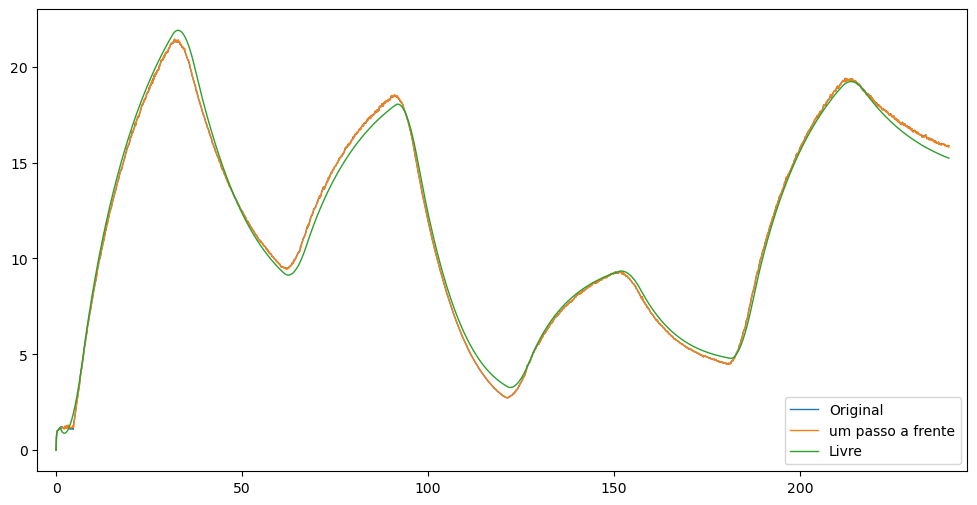

In [11]:

slivre = sselector.predict(u, y, theta, ss[selected], params[output]['nb'], params[output]['na'], output, params[output]['delay'], params[output]['diff'], dt=0.1)
yhat = sselector.oneStepForward(u, y, theta, ss[selected], params[output]['nb'], params[output]['na'], output, diff=True, dt=0.1)

print("\nSimulação livre")
metrics(y[output], slivre)
print("\nUm passo a frente")
metrics(y[output], yhat)

t = np.arange(0, y[0].shape[0], 1) * 0.1
plt.figure(figsize=(12,6))
#plt.title("Tanque " + str(output+1))
plt.plot(t, y[output].T, label='Original', linewidth=1.0)
plt.plot(t, yhat, label='um passo a frente', linewidth=1.0)
plt.plot(t, slivre, label='Livre', linewidth=1.0)
plt.xlim((-5,245))
plt.legend()
plt.show()

Simulação livre
0 [1]
--------s:  [Y1.1, Y1.2, Y2.1, Y2.2, d(Y1.1), d(Y2.1), U1.8, U1.9, U1.10, U1.11, U1.12, d(U1.1)]


Simulação livre
0 [1]
--------s:  [Y1.1, Y1.2, Y2.1, Y2.2, U1.8, U1.9, U1.10, U1.11, U1.12, U1.13, U1.14, U1.15]


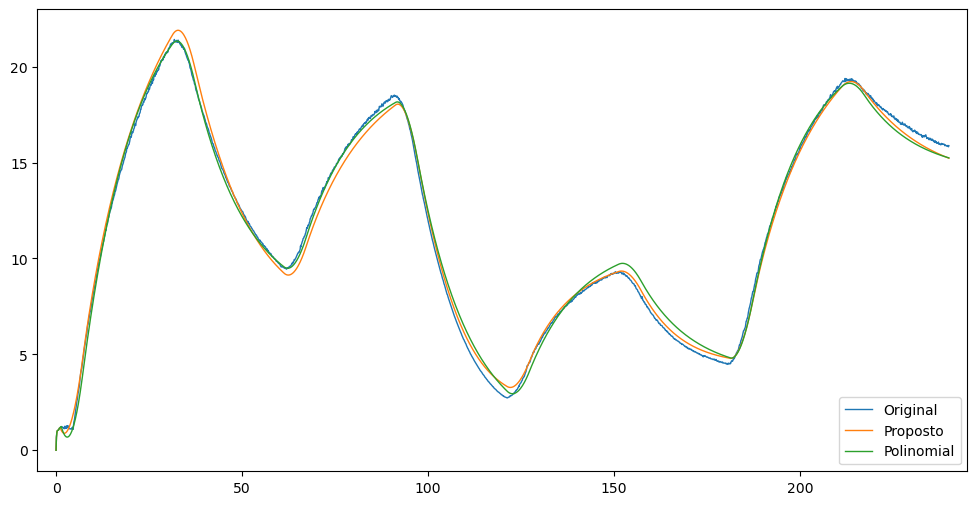

In [12]:
slivre1 = sselector.predict(u, y, theta, ss[selected], params[output]['nb'], params[output]['na'], output, params[output]['delay'], params[output]['diff'], dt=0.1)
tt = []
tt.append([ 0.99289921,  0.02485943, -0.07151722]) 
tt.append([ 0.65694291,  0.33397516,  0.0574249,  -0.04870856, -0.00104841])
sm = []
sm.append([symbols("Y1.1"), symbols('U1.12'), ss[0]])
sm.append([symbols("Y2.1"), symbols("Y2.2"), symbols("Y1.1"), symbols("Y1.2"), symbols("U1.2")])

pp = []
pp.append({'nb':[2,2],'na':[15], 'level':1, 'nonlinear':[0,0,0,0,0], 'root':False, 'delay':8, 'diff':False})
pp.append({'nb':[2,2],'na':[4], 'level':1, 'nonlinear':[0,0,0,0,0], 'root':False, 'delay':0, 'diff':False})

slivre2 = sselector.predict(u, y, tt[output], sm[output], pp[output]['nb'], pp[output]['na'], output, pp[output]['delay'], pp[output]['diff'], dt=0.1)

t = np.arange(0, y[0].shape[0], 1) * 0.1
plt.figure(figsize=(12,6))
plt.plot(t, y[output].T, label='Original', linewidth=1.0)
plt.plot(t, slivre1, label='Proposto', linewidth=1.0)
plt.plot(t, slivre2, label='Polinomial', linewidth=1.0)
plt.xlim((-5,245))
plt.legend()
plt.show()

## Validação

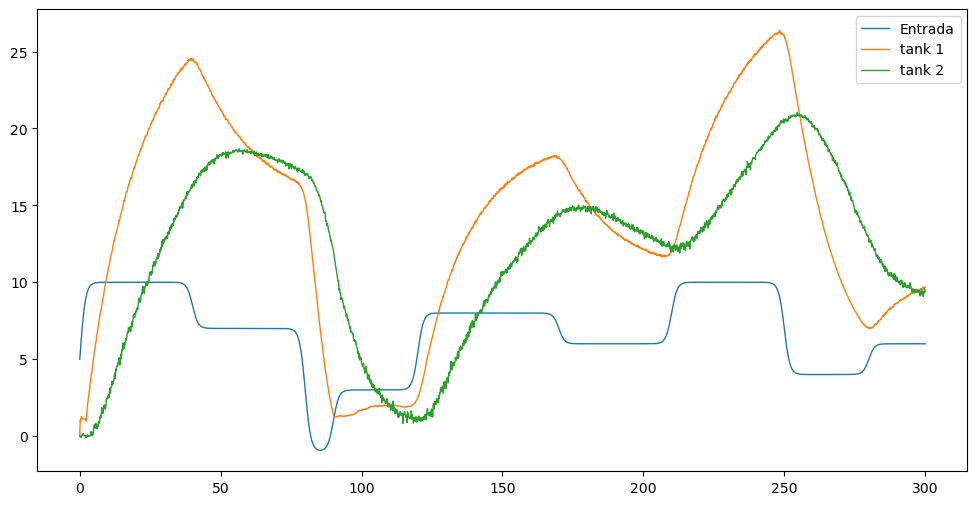

In [13]:
mat_content1 = sc.loadmat("data/ct1x1.mat")
mat_content2 = sc.loadmat("data/ct1x2.mat")

tanque1 = mat_content1['Tanque1']
tanque2 = mat_content2['Tanque2']

t1 = tanque1['time'][0][0]
v1 = tanque1['signals'][0][0]['values'][0][0]

t2 = tanque2['time'][0][0]
v2 = tanque2['signals'][0][0]['values'][0][0]

input = pd.read_csv('data/xinput.csv')
t = input['t']
uVal = np.array(input['v']).reshape((1,-1))


plt.figure(figsize=(12,6))
plt.plot(t, uVal.T, label='Entrada', linewidth=1.0)
plt.plot(t1, v1, label="tank 1", linewidth=1.0)
plt.plot(t2, v2, label="tank 2", linewidth=1.0)
plt.legend()
plt.show()

(2, 3001)
Simulação livre
0 [1]
--------s:  [Y1.1, Y1.2, Y2.1, Y2.2, U1.0, U1.1, U1.2, U1.3, U1.4, U1.5, U1.6, U1.7, U1.8, U1.9, U1.10, U1.11, U1.12]
Modelo selecionado:
0.0248563094786752⋅U1.12 + 1.00029920714266⋅Y1.1 - 0.0476886357675568⋅sqrtM(Y1
.1)

Simulação livre
RMSE: 0.6497755405319016 
MSE: 0.4222082530735249 
AET: 1720.6152845541033 
MAPE: 6.136%

Um passo a frente
RMSE: 0.039714026348609606 
MSE: 0.0015772038888180581 
AET: 90.51439167442786 
MAPE: 0.341%


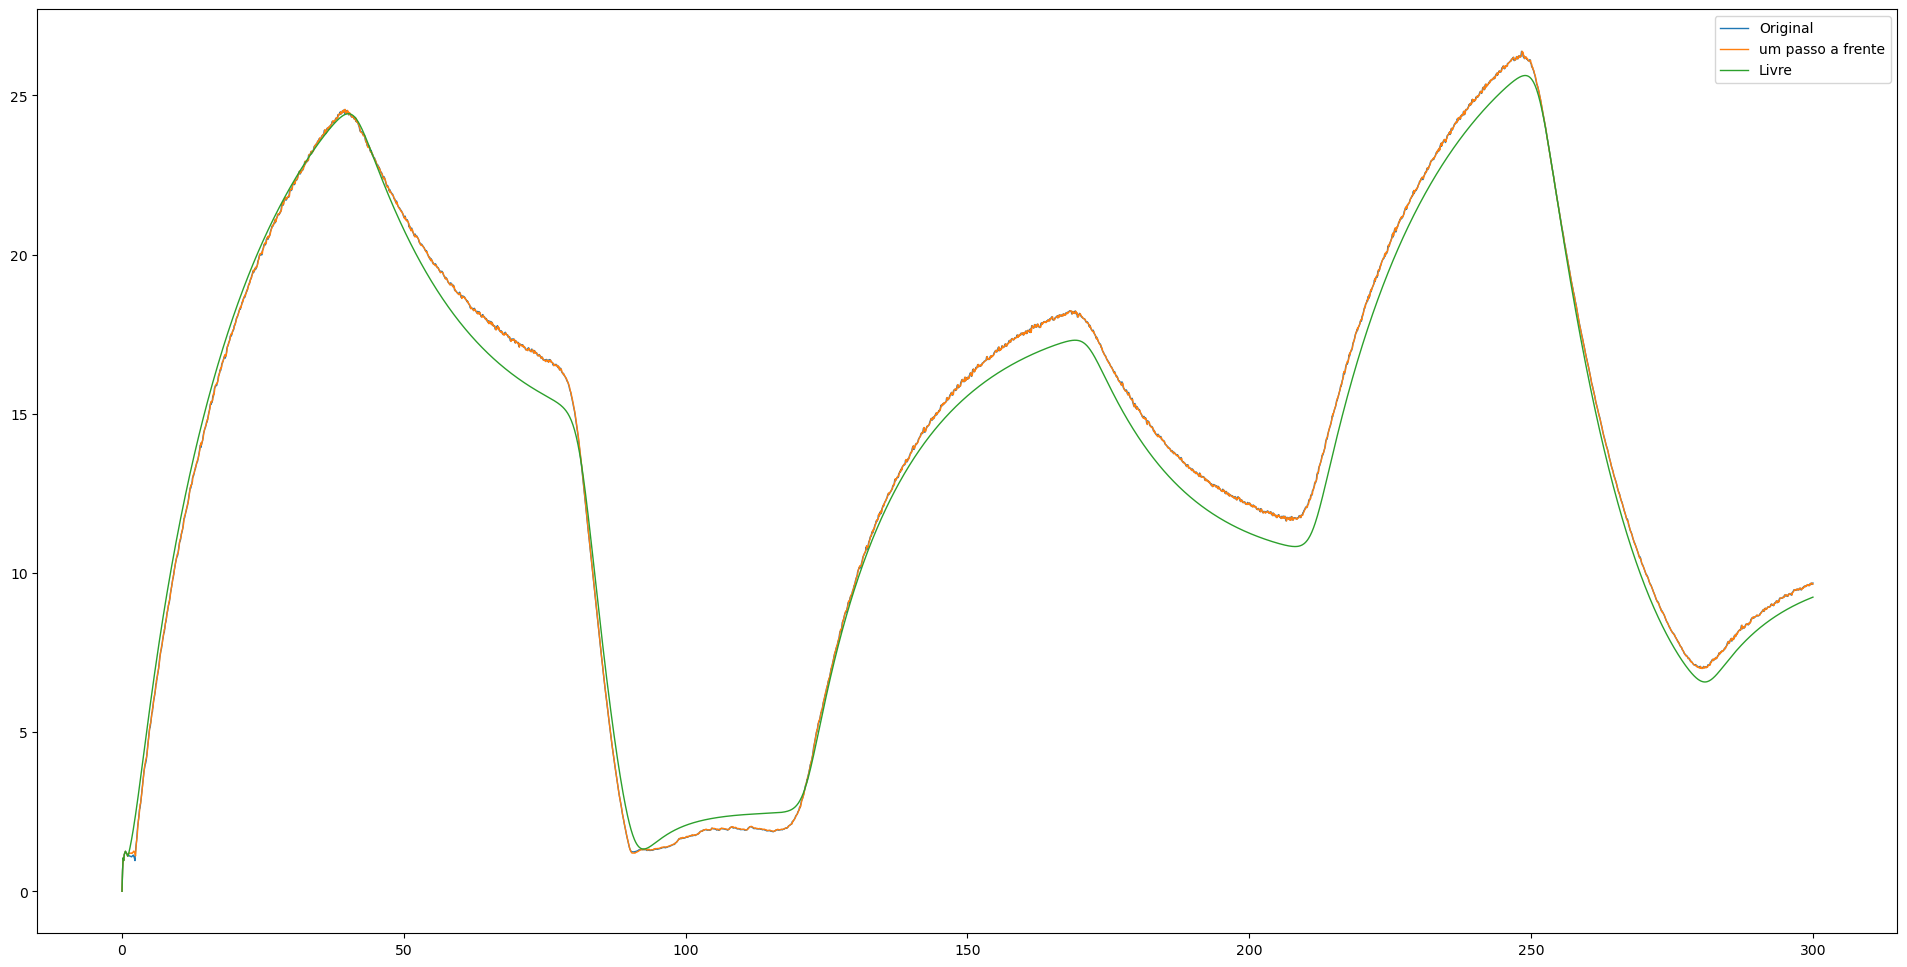

In [18]:
v1[v1 < 0] = 0
v2[v2 < 0] = 0
#v2[:100] = 0
yVal = np.vstack((v1.T, v2.T))
print(yVal.shape)
z = np.zeros(yVal.shape)
valLivre = sselector.predict(uVal, yVal, theta, ss[selected], params[output]['nb'], params[output]['na'], output)
yhat = sselector.oneStepForward(uVal, yVal, theta, ss[selected], params[output]['nb'], params[output]['na'], output)

print("Modelo selecionado:")
pprint( model @ theta)


print("\nSimulação livre")
metrics(yVal[output].T, valLivre)
print("\nUm passo a frente")
metrics(yVal[output].T, yhat)

f, ax = plt.subplots(1, 1, figsize=[24, 12])

plt.plot(t1, yVal[output].T, label='Original', linewidth=1.0)
plt.plot(t1, yhat, label='um passo a frente', linewidth=1.0)
plt.plot(t1, valLivre, label='Livre', linewidth=1.0)
#ax[0].set_title("Simulações")
plt.legend()
plt.savefig('figure/tank1Val.png')


'''ax[1].plot(t1, yVal[output].T - valLivre, label='Livre')
ax[1].plot(t1, yVal[output].T - yhat, label='um passo a frente')
ax[1].set_title("Resíduos")
ax[1].legend()'''
plt.show()

Simulação livre
0 [1]
--------s:  [Y1.1, Y1.2, Y2.1, Y2.2, d(Y1.1), d(Y2.1), U1.8, U1.9, U1.10, U1.11, U1.12, d(U1.1)]
Simulação livre
0 [1]
--------s:  [Y1.1, Y1.2, Y2.1, Y2.2, d(Y1.1), d(Y2.1), U1.8, U1.9, U1.10, U1.11, U1.12, d(U1.1)]


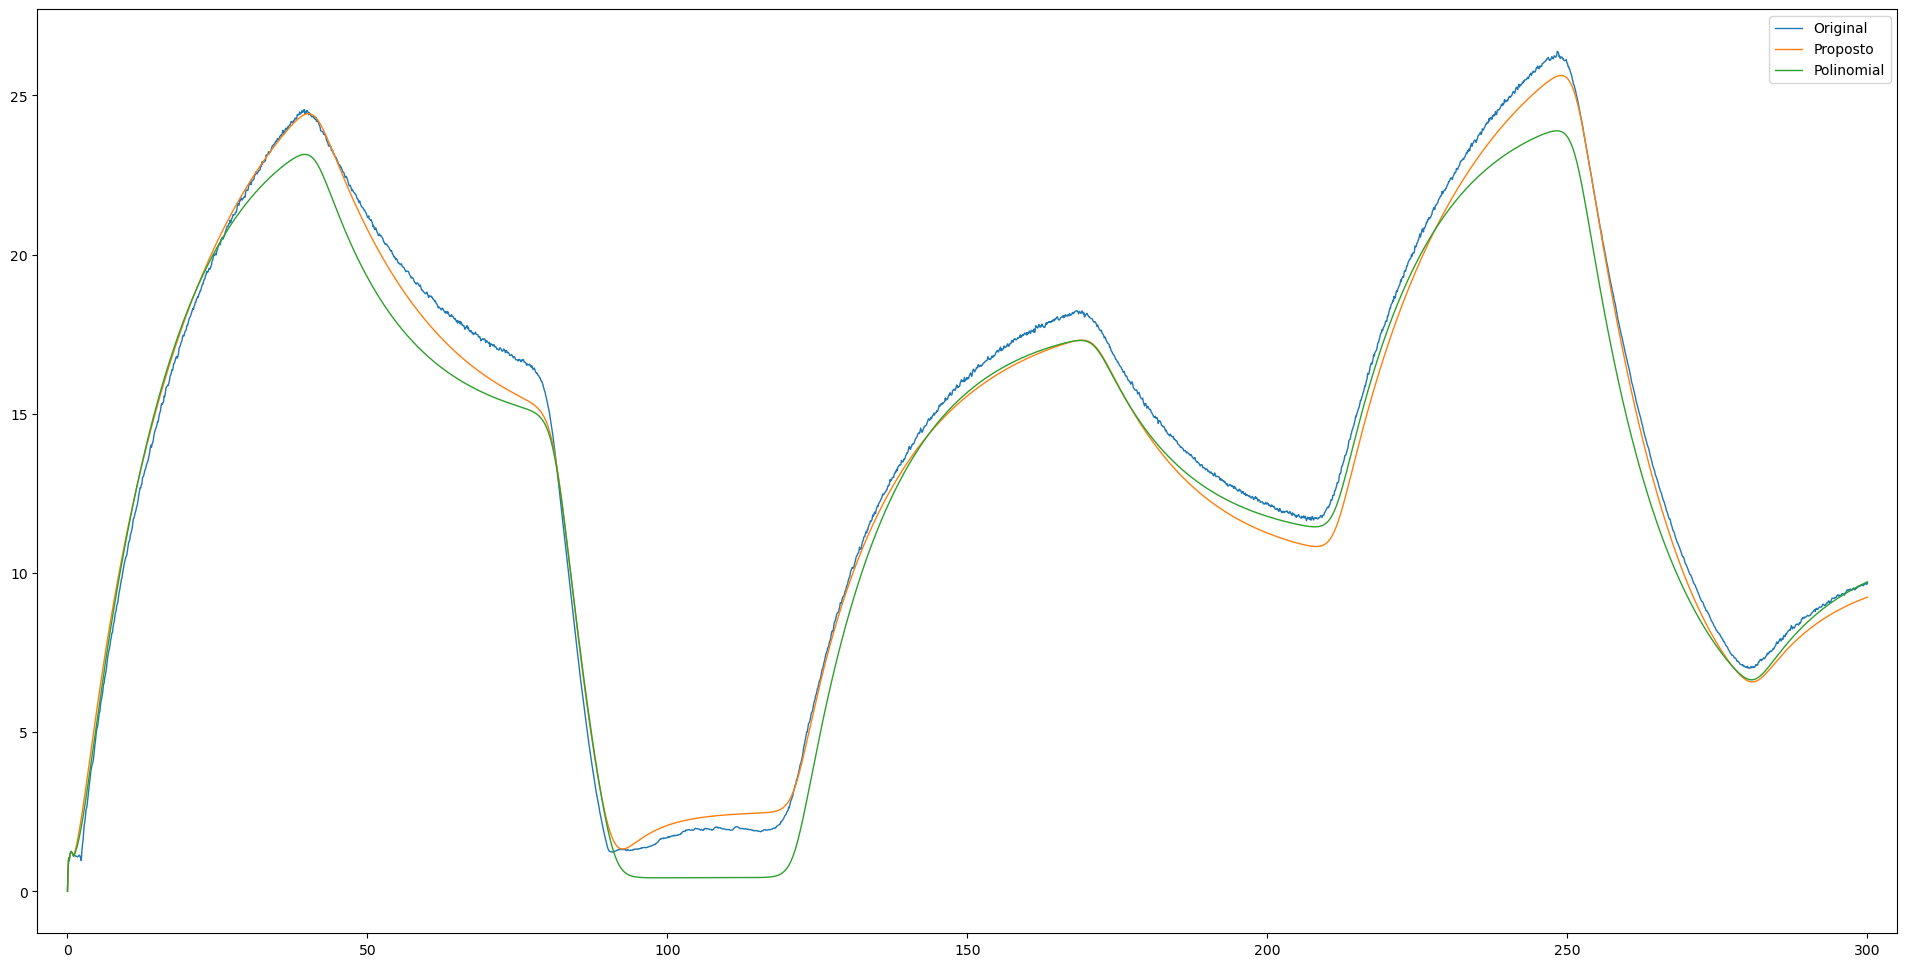

In [19]:
slivre1 = sselector.predict(uVal, yVal, theta, ss[selected], params[output]['nb'], params[output]['na'], output, params[output]['delay'], params[output]['diff'], dt=0.1)
tt = [ 0.99289921,  0.02485943, -0.07151722]
sm = [symbols("Y1.1"), symbols('U1.12'), ss[0]]
slivre2 = sselector.predict(uVal, yVal, tt, sm, params[output]['nb'], params[output]['na'], output, params[output]['delay'], params[output]['diff'], dt=0.1)

plt.figure(figsize=(24, 12))
plt.plot(t1, yVal[output].T, label='Original', linewidth=1.0)
plt.plot(t1, slivre1, label='Proposto', linewidth=1.0)
plt.plot(t1, slivre2, label='Polinomial', linewidth=1.0)
plt.xlim((-5, int(t1[-1, 0]) + 5))
plt.legend()
plt.savefig('figure/compTank1.png')
plt.show()